# Succesful Movies Inc.
---

### Introduction

In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import requests
from scipy.stats import linregress
from collections import Counter

In [2]:
# Read saved data
df = pd.read_csv("../Resources/all_movie_data_clean_df.csv")
TMBD_df = pd.read_csv("../Resources/TMBD Movie Dataset.csv")

# rename the imdb_id column so that they match when merging
TMBD_df.rename(columns={"imdb_id": "imdbID"}, inplace=True)

# Display sample data and delete unwanted columns
del df['Unnamed: 0']
print(df.shape)
df.columns

(1178, 26)


Index(['Title', 'Released', 'Year', 'Rated', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Language', 'Country', 'Ratings', 'Rotten Tomatoes',
       'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'BoxOffice', 'budget',
       'keywords', 'Production', 'Awards', 'oscar_wins', 'oscar_nominations',
       'award_wins', 'award_nominations'],
      dtype='object')

# Adding Columns to Main Dataset
---
### 

In [3]:
# merge the main df and the TMBD Movie Dataset.csv revenue and profit columns on the imdbID for each movie
df = pd.merge(df, TMBD_df[['imdbID', 'revenue', 'profit', 'popularity']], on="imdbID")

In [4]:
# calculate the combined average rating from the three 'Metascore','Rotten Tomatoes','imdbRating' and add as a column

# df['imdbRating'] = df['imdbRating'] * 10
# df = df.assign(Ratings_Combined = df.loc[:, ['Metascore','Rotten Tomatoes','imdbRating']].mean(axis=1)).round(2)
# df.head(2)

In [5]:
df = df[df['budget'] >=10000]

# Budget vs Box Office Revenue with IMDb Rating
---
### Summary

In [6]:
# Functions

# Define 2 different function to create Linear Regression plots
def regression_function(x_label, x_values, y_label, y_values, text_coordinates,):
    slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values, y_values, marker="o", facecolors="blue", edgecolors="black")
    plt.plot(x_values, regress_values,"r-")

    plt.annotate(line_eq, text_coordinates,fontsize=14,color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    print(f"The r-value is: {rvalue**2}")

def linear_regression_plot(x_values, y_values, title, x_label, y_label, x_equation, y_equation):

    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot scatter plot
    plt.scatter(x_values, y_values, marker='o', facecolors='blue', edgecolors='black', s=df['BoxOffice']*0.000001, alpha=0.50)

    # Plot regression line
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(x_equation, y_equation),fontsize=15,color="red")

    # Label plot
    plt.title(f'{title}')
    plt.xlabel(f'{x_label}')
    plt.ylabel(f'{y_label}')

    # Print r square value
    print(f"The r-value is: {rvalue**2}")

    # Show plot
    plt.show()

# Another function for oscar vs non-oscar comparison
def oscars_vs_non_comparison(df, column_name):
    copy_df = df.copy()
    winners = copy_df[copy_df['oscar_wins'] > 0].reset_index()
    non_winners = copy_df[copy_df['oscar_wins'] == 0].reset_index()

    winners_column_data = []
    non_winners_column_data = []

    for i in range(len(winners)):
        winners_list = winners[column_name][i]
        winners_list_split = winners_list.replace('[', '').replace(']', '').replace('\'', '').replace(' ', '').split(',')
        winners_column_data.extend(winners_list_split)

    for i in range(len(non_winners)):
        non_winners_list = non_winners[column_name][i]
        non_winners_list_split = non_winners_list.replace('[', '').replace(']', '').replace('\'', '').replace(' ', '').split(',')
        non_winners_column_data.extend(non_winners_list_split)

    winners_counts = Counter(winners_column_data)
    non_winners_counts = Counter(non_winners_column_data)
    
    winners_counts_df = pd.DataFrame.from_dict(winners_counts, orient='index').reset_index()
    winners_counts_df = winners_counts_df.rename(columns={'index': column_name, 0:'Count'})
    
    non_winners_counts_df = pd.DataFrame.from_dict(non_winners_counts, orient='index').reset_index()
    non_winners_counts_df = non_winners_counts_df.rename(columns={'index':column_name, 0:'Count'})
    
    winners_counts_df['percent of movies'] = 0
    for i in range(len(winners_counts_df)):
        winners_counts_df['percent of movies'][i] = (winners_counts_df['Count'][i] / len(winners_counts_df)) *100

    non_winners_counts_df['percent of movies'] = 0
    for i in range(len(non_winners_counts_df)):
        non_winners_counts_df['percent of movies'][i] = (non_winners_counts_df['Count'][i] / len(non_winners_counts_df)) *100
    
    oscars_vs_non = pd.merge(winners_counts_df, non_winners_counts_df, on= column_name, how='left')
    oscars_vs_non = oscars_vs_non.dropna()
    top_20 = oscars_vs_non.sort_values(by='Count_x', ascending=False).head(20)
    
    r1 = np.arange(20)
    width = 0.3

    plt.bar(r1, top_20['percent of movies_x'].sort_values(ascending=False), width, color='blue', label='Oscar Winners')
    plt.bar(r1 + 0.3, top_20['percent of movies_y'].sort_values(ascending=False), width, color='red', label='Non Oscar Winners')
    plt.xticks(rotation='vertical')
    plt.xlabel(column_name)
    plt.ylabel('Percent of Movies')
    plt.title(f'{column_name} Percentages in Oscar Winners vs Non Oscar Winners')
    plt.xticks(r1 + width / 2, top_20[column_name])
    plt.legend(loc='best')
    plt.tight_layout()

In [7]:
# Create budget_boxoffice_df DataFrame
budget_boxoffice_df = df[['Title', 'Genre', 'budget', 'revenue', 'imdbRating']].copy()

In [8]:
# Calculate return on investment (ROI) as percentage using
budget_boxoffice_df.loc[:, 'ROI'] = ((budget_boxoffice_df['revenue'] - budget_boxoffice_df['budget']) / budget_boxoffice_df['budget']) * 100

In [9]:
# Sort by ROI in descending order
budget_boxoffice_df.sort_values('ROI', ascending=False, inplace=True)

In [10]:
# Top 10 high-grossing movies with ROI and IMDb rating
top10_movies = budget_boxoffice_df.head(10)[['Title', 'Genre', 'budget', 'revenue', 'ROI', 'imdbRating']]
top10_movies = top10_movies.reset_index(drop=True)

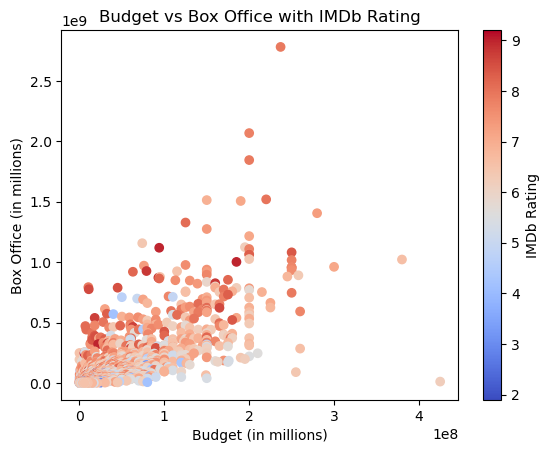

In [11]:
# Plotting scatter plot of budget vs box office with IMDb rating as color
plt.scatter(budget_boxoffice_df['budget'], budget_boxoffice_df['revenue'], c=budget_boxoffice_df['imdbRating'], cmap='coolwarm')
plt.colorbar(label='IMDb Rating')
plt.xlabel('Budget (in millions)')
plt.ylabel('Box Office (in millions)')
plt.title('Budget vs Box Office with IMDb Rating')
plt.show()

The r-value is: 0.49101587528649004


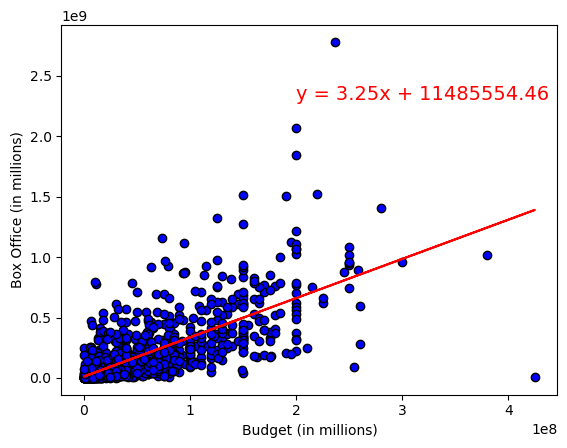

In [12]:
regression_function("Budget (in millions)", df["budget"], "Box Office (in millions)", df["revenue"], (2e8, 2.3e9))

In [13]:
# Display top 10 high-grossing movies with ROI and IMDb rating
print('Top 10 High-Grossing Movies with ROI and IMDb Rating:')
print("-----------------------------------------------------")
print(top10_movies)

Top 10 High-Grossing Movies with ROI and IMDb Rating:
-----------------------------------------------------
                                Title                                 Genre  \
0                 Paranormal Activity                ['Horror', ' Mystery']   
1             The Blair Witch Project                ['Horror', ' Mystery']   
2                         The Gallows   ['Horror', ' Mystery', ' Thriller']   
3                           Halloween               ['Horror', ' Thriller']   
4                                Once       ['Drama', ' Music', ' Romance']   
5                              Clerks                            ['Comedy']   
6                    The Devil Inside                            ['Horror']   
7       The Rocky Horror Picture Show     ['Comedy', ' Horror', ' Musical']   
8          E.T. the Extra-Terrestrial   ['Adventure', ' Family', ' Sci-Fi']   
9  Star Wars: Episode IV - A New Hope  ['Action', ' Adventure', ' Fantasy']   

     budget      reven

# Top 10 Multigenres for Oscar movies vs. Non-Oscar movies
---
### Summary

In [14]:
oscar_movies = df.loc[(df["oscar_wins"] > 0) | (df["oscar_nominations"] > 0)].reset_index(drop=True)
other_movies = df.loc[(df["oscar_wins"] == 0) & (df["oscar_nominations"] == 0)]

In [15]:
oscar_movies_multigenre_count = pd.DataFrame(oscar_movies["Genre"].value_counts())
oscar_movies_multigenre_count = oscar_movies_multigenre_count.rename_axis("Genre")
oscar_movies_multigenre_count = oscar_movies_multigenre_count.rename(columns={"Genre":"Count"})
oscar_movies_multigenre_count.head(10)

,Count
Genre,
"['Animation', ' Adventure', ' Comedy']",37
"['Action', ' Adventure', ' Sci-Fi']",21
"['Comedy', ' Drama', ' Romance']",16
"['Drama', ' Romance']",15
"['Action', ' Adventure', ' Thriller']",14
"['Action', ' Adventure', ' Fantasy']",11
"['Action', ' Adventure', ' Drama']",10
"['Animation', ' Action', ' Adventure']",9
['Drama'],9


In [16]:
other_movies_multigenre_count = pd.DataFrame(other_movies["Genre"].value_counts())
other_movies_multigenre_count = other_movies_multigenre_count.rename_axis("Genre")
other_movies_multigenre_count = other_movies_multigenre_count.rename(columns={"Genre":"Count"})
other_movies_multigenre_count.head(10)

,Count
Genre,
"['Comedy', ' Romance']",37
"['Animation', ' Adventure', ' Comedy']",35
"['Comedy', ' Drama', ' Romance']",33
"['Action', ' Adventure', ' Sci-Fi']",32
"['Action', ' Crime', ' Thriller']",22
"['Action', ' Adventure', ' Thriller']",22
"['Action', ' Crime', ' Drama']",22
"['Comedy', ' Drama']",22
"['Action', ' Adventure', ' Comedy']",19


In [17]:
oscar_movies_multigenre_count10 = oscar_movies_multigenre_count.head(10)

In [18]:
oscar_movies_multigenre_count10_copy = oscar_movies_multigenre_count10.copy()

In [19]:
oscar_movies_multigenre_count10_copy.loc[:, "Animation"] = np.array([37/3,0,0,0,0,0,0,9/3,0,0])
oscar_movies_multigenre_count10_copy.loc[:, "Action"] = np.array([0,21/3,0,0,14/3,11/3,10/3,9/3,0,0])
oscar_movies_multigenre_count10_copy.loc[:, "Adventure"] = np.array([37/3,21/3,0,0,14/3,11/3,10/3,9/3,0,0])
oscar_movies_multigenre_count10_copy.loc[:, "Biography"] = np.array([0,0,0,0,0,0,0,0,0,9/3])
oscar_movies_multigenre_count10_copy.loc[:, "Comedy"] = np.array([37/3,0,16/3,0,0,0,0,0,0,0])
oscar_movies_multigenre_count10_copy.loc[:, "Drama"] = np.array([0,0,16/3,15/2,0,0,10/3,0,9,9/3])
oscar_movies_multigenre_count10_copy.loc[:, "Fantasy"] = np.array([0,0,0,0,0,11/3,0,0,0,0])
oscar_movies_multigenre_count10_copy.loc[:, "History"] = np.array([0,0,0,0,0,0,0,0,0,9/3])
oscar_movies_multigenre_count10_copy.loc[:, "Romance"] = np.array([0,0,16/3,15/2,0,0,0,0,0,0])
oscar_movies_multigenre_count10_copy.loc[:, "Sci-Fi"] = np.array([0,21/3,0,0,0,0,0,0,0,0])
oscar_movies_multigenre_count10_copy.loc[:, "Thriller"] = np.array([0,0,0,0,14/3,0,0,0,0,0])

oscar_movies_multigenre_count10

,Count
Genre,
"['Animation', ' Adventure', ' Comedy']",37
"['Action', ' Adventure', ' Sci-Fi']",21
"['Comedy', ' Drama', ' Romance']",16
"['Drama', ' Romance']",15
"['Action', ' Adventure', ' Thriller']",14
"['Action', ' Adventure', ' Fantasy']",11
"['Action', ' Adventure', ' Drama']",10
"['Animation', ' Action', ' Adventure']",9
['Drama'],9


In [20]:
other_movies_multigenre_count10 = other_movies_multigenre_count.head(10) 

In [21]:
other_movies_multigenre_count10_copy = other_movies_multigenre_count10.copy()

In [22]:
other_movies_multigenre_count10_copy.loc[:, "Animation"] = np.array([0,35/3,0,0,0,0,0,0,0,0])
other_movies_multigenre_count10_copy.loc[:, "Action"] = np.array([0,0,0,32/3,22/3,22/3,22/3,0,19/3,0])
other_movies_multigenre_count10_copy.loc[:, "Adventure"] = np.array([0,35/3,0,32/3,0,22/3,0,0,19/3,0])
other_movies_multigenre_count10_copy.loc[:, "Comedy"] = np.array([37/2,35/3,33/3,0,0,0,0,22/2,19/3,0])
other_movies_multigenre_count10_copy.loc[:, "Crime"] = np.array([0,0,0,0,22/3,0,22/3,0,0,0])
other_movies_multigenre_count10_copy.loc[:, "Drama"] = np.array([0,0,33/3,0,0,0,22/3,22/2,0,0])
other_movies_multigenre_count10_copy.loc[:, "Horror"] = np.array([0,0,0,0,0,0,0,0,0,19/3])
other_movies_multigenre_count10_copy.loc[:, "Mystery"] = np.array([0,0,0,0,0,0,0,0,0,19/3])
other_movies_multigenre_count10_copy.loc[:, "Romance"] = np.array([37/2,0,33/3,0,0,0,0,0,0,0])
other_movies_multigenre_count10_copy.loc[:, "Sci-Fi"] = np.array([0,0,0,32/3,0,0,0,0,0,0])
other_movies_multigenre_count10_copy.loc[:, "Thriller"] = np.array([0,0,0,0,22/3,22/3,0,0,0,19/3])

other_movies_multigenre_count10

,Count
Genre,
"['Comedy', ' Romance']",37
"['Animation', ' Adventure', ' Comedy']",35
"['Comedy', ' Drama', ' Romance']",33
"['Action', ' Adventure', ' Sci-Fi']",32
"['Action', ' Crime', ' Thriller']",22
"['Action', ' Adventure', ' Thriller']",22
"['Action', ' Crime', ' Drama']",22
"['Comedy', ' Drama']",22
"['Action', ' Adventure', ' Comedy']",19


<Axes: title={'center': 'Oscar Movies Top 10 Multigenres'}, xlabel='Count', ylabel='Multigenre'>

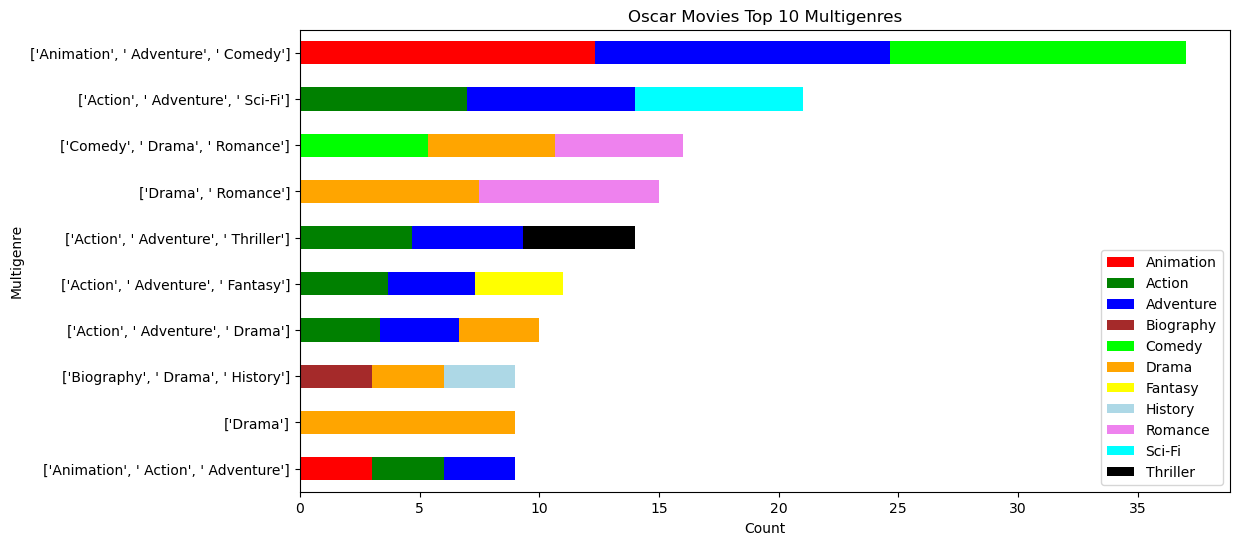

In [23]:
colors = "red","green","blue","brown","lime","orange","yellow","lightblue","violet","cyan","black"
oscar_movies_multigenre_count10_copy.sort_values(by="Count", ascending=True).iloc[0:10, 1:12].plot(kind='barh', stacked=True, color=colors, 
                                                                                            figsize = (12, 6), title="Oscar Movies Top 10 Multigenres",
                                                                                            xlabel="Count", ylabel="Multigenre")

<Axes: title={'center': 'Non-Oscar Movies Top 10 Multigenres'}, xlabel='Count', ylabel='Multigenre'>

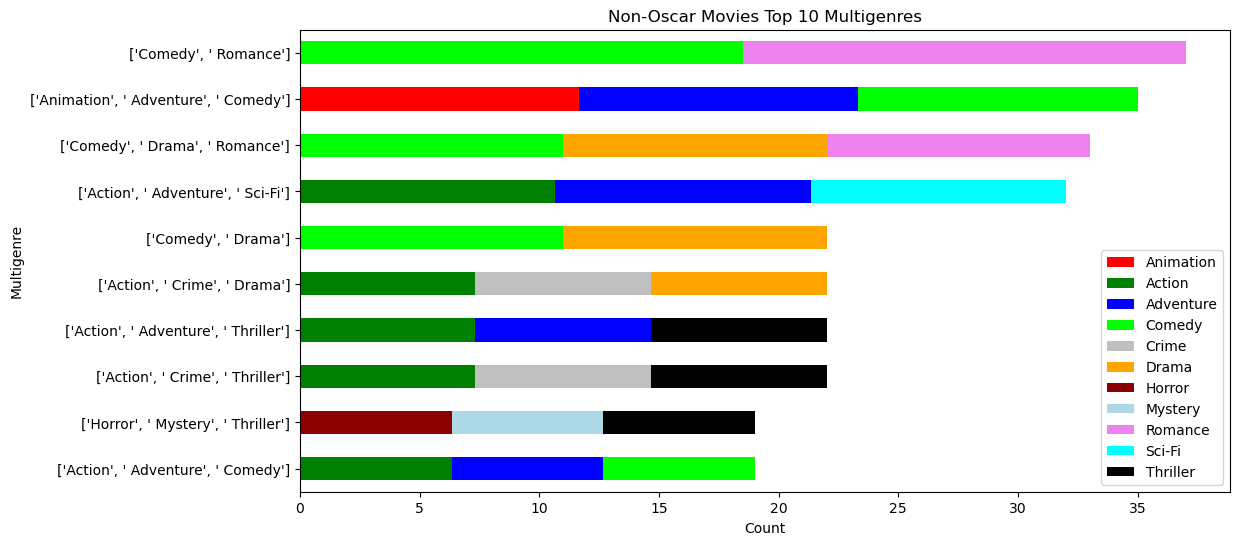

In [24]:
colors = "red","green","blue","lime","silver","orange","darkred","lightblue","violet","cyan","black"
other_movies_multigenre_count10_copy.sort_values(by="Count", ascending=True).iloc[0:10, 1:12].plot(kind='barh', stacked=True, color=colors, 
                                                                                            figsize = (12, 6), title="Non-Oscar Movies Top 10 Multigenres",
                                                                                            xlabel="Count", ylabel="Multigenre")

In [25]:
top10_average = df.groupby(["Genre"]).mean(numeric_only=True)
top10_sum = df.groupby(["Genre"]).sum(numeric_only=True)

In [26]:
top10_average = top10_average[['profit', 'revenue', 'budget', 'imdbRating', 'popularity']]
top10_average.sort_values(by='profit', ascending=False).head(10)

,profit,revenue,budget,imdbRating,popularity
Genre,,,,,
"['Adventure', ' Family', ' Sci-Fi']",7.824106e+08,7.929106e+08,1.050000e+07,7.900000,2.900556
['Fantasy'],7.377018e+08,9.877018e+08,2.500000e+08,7.800000,4.264860
"['Adventure', ' Fantasy']",7.051198e+08,9.551198e+08,2.500000e+08,7.400000,10.174599
"['Adventure', ' Family', ' Fantasy']",5.036482e+08,6.518300e+08,1.481818e+08,6.927273,3.812306
"['Adventure', ' Thriller']",4.636540e+08,4.706540e+08,7.000000e+06,8.100000,2.563191
"['Adventure', ' Drama', ' Fantasy']",4.425809e+08,5.130309e+08,7.045000e+07,6.175000,1.857365
"['Action', ' Drama', ' Horror']",4.353490e+08,5.853490e+08,1.500000e+08,7.200000,2.692916
"['Action', ' Sci-Fi']",4.095675e+08,5.409103e+08,1.313429e+08,7.514286,3.888459
"['Action', ' Adventure', ' Sci-Fi']",3.946983e+08,5.409624e+08,1.462642e+08,6.652830,5.056460


In [27]:
top10_average.sort_values(by='imdbRating', ascending=False).head(10)

,profit,revenue,budget,imdbRating,popularity
Genre,,,,,
"['Drama', ' Mystery', ' War']",5.197151e+07,83471511.0,3.150000e+07,8.5,2.319520
"['Adventure', ' Drama', ' War']",2.491310e+08,319131050.0,7.000000e+07,8.3,6.098027
"['Documentary', ' Crime']",5.871522e+06,7871522.0,2.000000e+06,8.2,1.003782
"['Adventure', ' Thriller']",4.636540e+08,470654000.0,7.000000e+06,8.1,2.563191
"['Drama', ' Western']",2.698226e+08,338822582.5,6.900000e+07,8.0,4.022611
"['Documentary', ' Crime', ' Drama']",3.156447e+07,35564473.0,4.000000e+06,8.0,1.005772
"['Animation', ' Family', ' Fantasy']",3.523506e+08,377350553.0,2.500000e+07,8.0,3.852269
"['Drama', ' Sport']",1.127338e+08,130733820.5,1.800000e+07,8.0,1.451741
"['Adventure', ' Family', ' Sci-Fi']",7.824106e+08,792910554.0,1.050000e+07,7.9,2.900556


In [28]:
top10_average.sort_values(by='revenue', ascending=False).head(10)

,profit,revenue,budget,imdbRating,popularity
Genre,,,,,
['Fantasy'],7.377018e+08,9.877018e+08,2.500000e+08,7.800000,4.264860
"['Adventure', ' Fantasy']",7.051198e+08,9.551198e+08,2.500000e+08,7.400000,10.174599
"['Adventure', ' Family', ' Sci-Fi']",7.824106e+08,7.929106e+08,1.050000e+07,7.900000,2.900556
"['Adventure', ' Family', ' Fantasy']",5.036482e+08,6.518300e+08,1.481818e+08,6.927273,3.812306
"['Action', ' Drama', ' Horror']",4.353490e+08,5.853490e+08,1.500000e+08,7.200000,2.692916
"['Action', ' Adventure', ' Sci-Fi']",3.946983e+08,5.409624e+08,1.462642e+08,6.652830,5.056460
"['Action', ' Sci-Fi']",4.095675e+08,5.409103e+08,1.313429e+08,7.514286,3.888459
"['Action', ' Comedy', ' Sci-Fi']",3.886022e+08,5.186022e+08,1.300000e+08,7.300000,5.573184
"['Action', ' Adventure', ' Fantasy']",3.927626e+08,5.131089e+08,1.203463e+08,6.655556,3.555011


In [29]:
top10_average.sort_values(by='popularity', ascending=False).head(10)

,profit,revenue,budget,imdbRating,popularity
Genre,,,,,
"['Adventure', ' Drama', ' Sci-Fi']",3.491789e+08,4.601789e+08,1.110000e+08,7.20000,11.086397
"['Adventure', ' Fantasy']",7.051198e+08,9.551198e+08,2.500000e+08,7.40000,10.174599
"['Adventure', ' Drama', ' War']",2.491310e+08,3.191310e+08,7.000000e+07,8.30000,6.098027
"['Action', ' Comedy', ' Sci-Fi']",3.886022e+08,5.186022e+08,1.300000e+08,7.30000,5.573184
"['Action', ' Adventure', ' Sci-Fi']",3.946983e+08,5.409624e+08,1.462642e+08,6.65283,5.056460
"['Biography', ' Drama', ' Thriller']",1.108723e+08,1.288723e+08,1.800000e+07,7.40000,4.432440
['Fantasy'],7.377018e+08,9.877018e+08,2.500000e+08,7.80000,4.264860
"['Action', ' Fantasy']",2.941150e+08,4.441150e+08,1.500000e+08,7.00000,4.123520
"['Action', ' Fantasy', ' Thriller']",8.650125e+07,1.462513e+08,5.975000e+07,5.80000,4.088957


In [30]:
top10_sum = top10_sum[['imdbVotes', 'oscar_wins', 'oscar_nominations']]
top10_sum.sort_values(by='imdbVotes', ascending=False).head(10)

,imdbVotes,oscar_wins,oscar_nominations
Genre,,,
"['Action', ' Adventure', ' Sci-Fi']",27309347,16,25
"['Animation', ' Adventure', ' Comedy']",18880956,16,37
"['Action', ' Adventure', ' Fantasy']",14012073,11,17
"['Action', ' Adventure', ' Drama']",9187768,23,10
"['Comedy', ' Drama', ' Romance']",8773347,11,19
"['Action', ' Adventure', ' Thriller']",8177790,7,11
"['Action', ' Crime', ' Drama']",7896649,2,8
['Drama'],6830860,8,13
"['Action', ' Sci-Fi']",6740021,4,2


In [31]:
top10_sum.sort_values(by='oscar_wins', ascending=False).head(10)

,imdbVotes,oscar_wins,oscar_nominations
Genre,,,
"['Drama', ' Romance']",5965534,24,20
"['Action', ' Adventure', ' Drama']",9187768,23,10
"['Action', ' Adventure', ' Sci-Fi']",27309347,16,25
"['Animation', ' Adventure', ' Comedy']",18880956,16,37
"['Biography', ' Drama', ' History']",3207149,16,10
"['Comedy', ' Drama', ' Romance']",8773347,11,19
"['Biography', ' Drama']",2798558,11,3
"['Action', ' Adventure', ' Fantasy']",14012073,11,17
"['Crime', ' Drama', ' Romance']",1026068,9,4


In [32]:
top10_sum.sort_values(by='oscar_nominations', ascending=False).head(10)

,imdbVotes,oscar_wins,oscar_nominations
Genre,,,
"['Animation', ' Adventure', ' Comedy']",18880956,16,37
"['Crime', ' Drama']",4836120,5,29
"['Action', ' Adventure', ' Sci-Fi']",27309347,16,25
"['Drama', ' Romance']",5965534,24,20
"['Comedy', ' Drama', ' Romance']",8773347,11,19
"['Action', ' Adventure', ' Fantasy']",14012073,11,17
['Drama'],6830860,8,13
"['Action', ' Adventure', ' Thriller']",8177790,7,11
"['Action', ' Drama', ' Sci-Fi']",3983948,0,10


# Award Wins vs Oscar Wins vs Box Office Revenue
---

The r-value is: 0.552479843948513


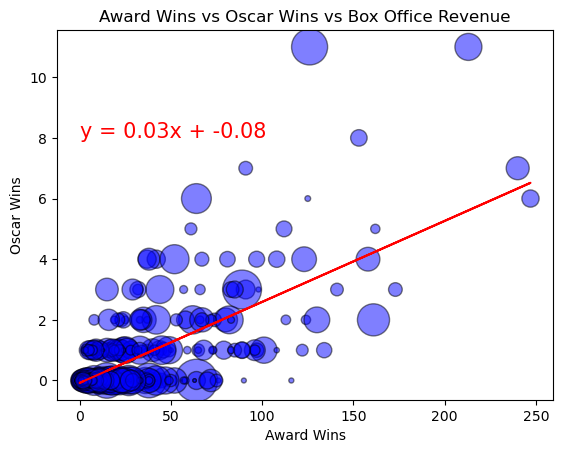

In [33]:
linear_regression_plot(df['award_wins'], df['oscar_wins'],'Award Wins vs Oscar Wins vs Box Office Revenue', 'Award Wins', 'Oscar Wins', 0, 8)

C:\Users\Kirby\AppData\Local\Temp\ipykernel_23248\4238824857.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_counts_df['percent of movies'][i] = (winners_counts_df['Count'][i] / len(winners_counts_df)) *100
C:\Users\Kirby\AppData\Local\Temp\ipykernel_23248\4238824857.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_winners_counts_df['percent of movies'][i] = (non_winners_counts_df['Count'][i] / len(non_winners_counts_df)) *100


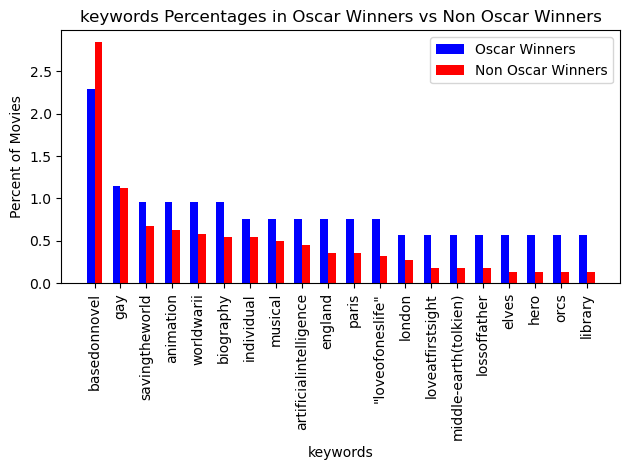

In [34]:
oscars_vs_non_comparison(df, 'keywords')

# Movie Film Ratings (G, PG, PG-13, R) Analysis
---

In [35]:
df_G= df.loc[(df["Rated"] == "G")].reset_index(drop=True)
df_PG= df.loc[(df["Rated"] == "PG")].reset_index(drop=True)
df_PG13= df.loc[(df["Rated"] == "PG-13")].reset_index(drop=True)
df_R = df.loc[(df["Rated"] == "R")].reset_index(drop=True)

In [36]:
top_G = df_G[["imdbRating", "budget", "imdbVotes", "popularity", "revenue", "profit", "Year", "Released", "oscar_wins", "oscar_nominations", "award_wins", "award_nominations"]].reset_index(drop=True)
top_PG = df_PG[["imdbRating", "budget", "imdbVotes", "popularity", "revenue", "profit", "Year", "Released", "oscar_wins", "oscar_nominations", "award_wins", "award_nominations"]].reset_index(drop=True)
top_PG13 = df_PG13[["imdbRating", "budget", "imdbVotes", "popularity", "revenue", "profit", "Year", "Released", "oscar_wins", "oscar_nominations", "award_wins", "award_nominations"]].reset_index(drop=True)
top_R = df_R[["imdbRating", "budget", "imdbVotes", "popularity", "revenue", "profit", "Year", "Released", "oscar_wins", "oscar_nominations", "award_wins", "award_nominations"]].reset_index(drop=True)

In [37]:
top_G.mean(numeric_only=True).apply(lambda x: '%.2f' % x)

imdbRating                   7.09
budget                84089285.71
imdbVotes               368821.43
popularity                   2.29
revenue              357689561.86
profit               273600276.14
Year                      2002.57
oscar_wins                   0.46
oscar_nominations            0.61
award_wins                  20.46
award_nominations           28.43
dtype: object

In [38]:
top_PG.mean(numeric_only=True).apply(lambda x: '%.2f' % x)

imdbRating                   6.55
budget                68678970.61
imdbVotes               201897.42
popularity                   1.81
revenue              248316333.24
profit               179637362.63
Year                      2003.84
oscar_wins                   0.24
oscar_nominations            0.41
award_wins                   9.00
award_nominations           19.83
dtype: object

In [39]:
top_PG13.mean(numeric_only=True).apply(lambda x: '%.2f' % x)

imdbRating                   6.53
budget                74408251.82
imdbVotes               295066.21
popularity                   2.25
revenue              259726012.83
profit               185317761.01
Year                      2008.87
oscar_wins                   0.24
oscar_nominations            0.36
award_wins                  11.88
award_nominations           25.11
dtype: object

In [40]:
top_R.mean(numeric_only=True).apply(lambda x: '%.2f' % x)

imdbRating                  6.74
budget               29288507.24
imdbVotes              242483.42
popularity                  1.55
revenue              90394267.09
profit               61105759.85
Year                     2006.88
oscar_wins                  0.25
oscar_nominations           0.36
award_wins                 13.78
award_nominations          27.23
dtype: object

In [41]:
top_G_group = (top_G.groupby(['Year'])['profit'].mean())
top_PG_group = (top_PG.groupby(['Year'])['profit'].mean())
top_PG13_group = (top_PG13.groupby(['Year'])['profit'].mean())
top_R_group = (top_R.groupby(['Year'])['profit'].mean())

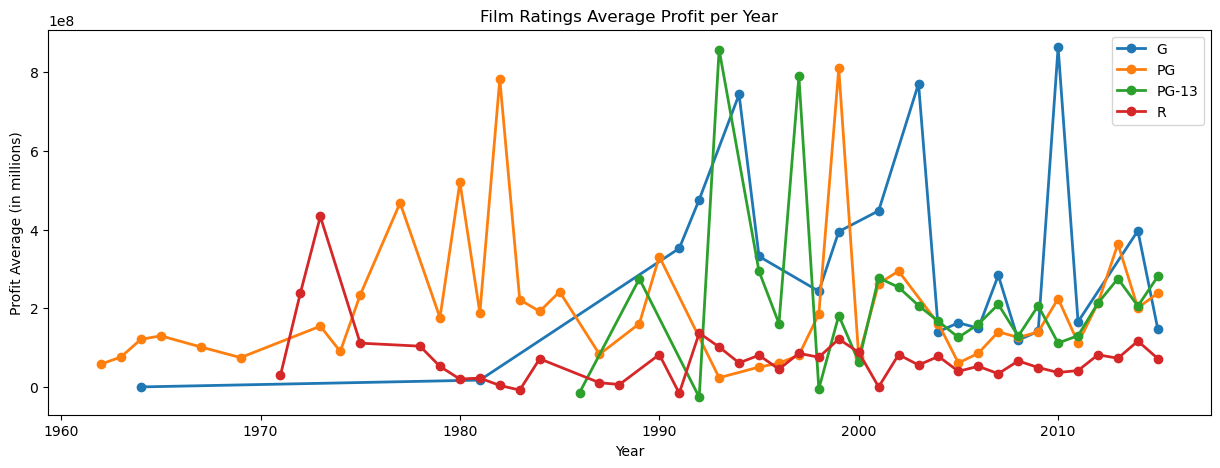

In [42]:
plt.figure(figsize=(15,5))
top_G_group.plot(label="G", marker='o',linewidth=2,markersize=6)
top_PG_group.plot(label="PG", marker='o',linewidth=2,markersize=6)
top_PG13_group.plot(label="PG-13", marker='o',linewidth=2,markersize=6)
top_R_group.plot(label="R", marker='o',linewidth=2,markersize=6)
plt.title("Film Ratings Average Profit per Year")
plt.ylabel("Profit Average (in millions)")
plt.legend()
plt.show()

In [43]:
top_G_group2 = (top_G.groupby(['Year'])['budget'].mean())
top_PG_group2 = (top_PG.groupby(['Year'])['budget'].mean())
top_PG13_group2 = (top_PG13.groupby(['Year'])['budget'].mean())
top_R_group2 = (top_R.groupby(['Year'])['budget'].mean())

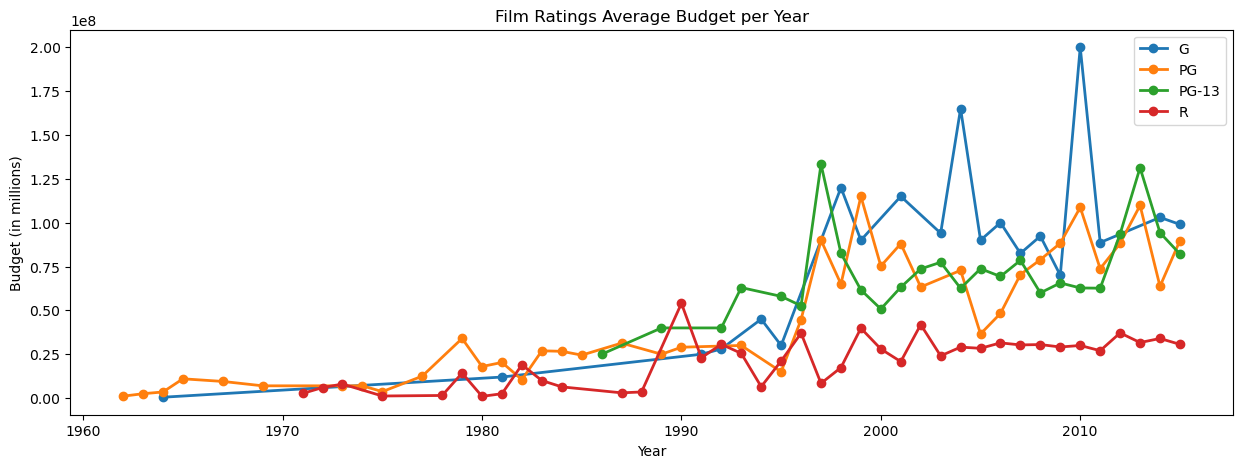

In [44]:
plt.figure(figsize=(15,5))
top_G_group2.plot(label="G", marker='o',linewidth=2,markersize=6)
top_PG_group2.plot(label="PG", marker='o',linewidth=2,markersize=6)
top_PG13_group2.plot(label="PG-13", marker='o',linewidth=2,markersize=6)
top_R_group2.plot(label="R", marker='o',linewidth=2,markersize=6)
plt.title("Film Ratings Average Budget per Year")
plt.ylabel("Budget (in millions)")
plt.legend()
plt.show()

In [45]:
top_G_group3 = (top_G.groupby(['Year'])['popularity'].mean())
top_PG_group3 = (top_PG.groupby(['Year'])['popularity'].mean())
top_PG13_group3 = (top_PG13.groupby(['Year'])['popularity'].mean())
top_R_group3 = (top_R.groupby(['Year'])['popularity'].mean())

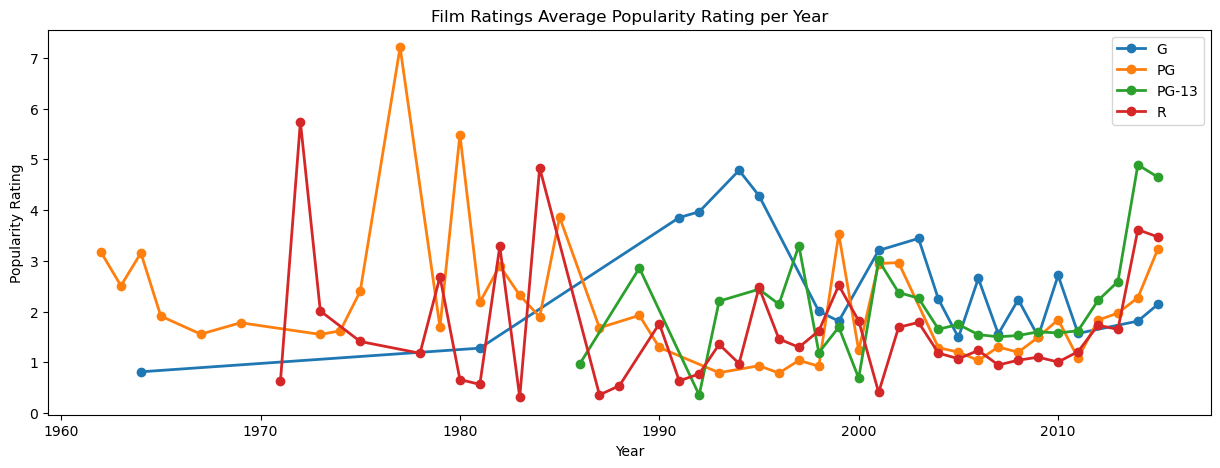

In [46]:
plt.figure(figsize=(15,5))
top_G_group3.plot(label="G", marker='o',linewidth=2,markersize=6)
top_PG_group3.plot(label="PG", marker='o',linewidth=2,markersize=6)
top_PG13_group3.plot(label="PG-13", marker='o',linewidth=2,markersize=6)
top_R_group3.plot(label="R", marker='o',linewidth=2,markersize=6)
plt.title("Film Ratings Average Popularity Rating per Year")
plt.ylabel("Popularity Rating")
plt.legend()
plt.show()

# Top 10 Directors vs Revenue and Runtime Regression
---

In [47]:
#Generating Summary statistics for mean and median
summary_statistics = df.groupby('Director').agg({'revenue':['mean', 'median']})
summary_statistics

revenue             
                                       mean       median
Director                                                
["Gavin O'Connor"]               27102721.5   27102721.5
["Steve 'Spaz' Williams"]        37384046.0   37384046.0
['Adam McKay']                  155581870.0  162966177.0
['Adam Shankman']                76025642.5   74934310.5
['Agnieszka Wojtowicz-Vosloo']    3606395.0    3606395.0
...                                     ...          ...
['Woody Allen']                  31584901.0   31584901.0
['Yorgos Lanthimos']              9064511.0    9064511.0
['Zack Snyder']                 283535642.0  140073390.0
['Zal Batmanglij']                2401510.0    2401510.0
['Émile Gaudreault']              3031801.0    3031801.0

[715 rows x 2 columns]

In [48]:
#Calculating the number of movies based on directors
director_count = df['Director'].value_counts().rename('director_movie_count')

df = df.merge(director_count.to_frame(),
                                left_on='Director',
                                right_index=True)

In [111]:
#calculating top 10 directors based on revenue
All_Rev_directors = df.groupby('Director').agg({'revenue': 'mean', 'Title': 'count'})
AllDirectors = All_Rev_directors.sort_values('revenue', ascending=False)[:10]
AllDirectors

,revenue,Title
Director,,
['James Cameron'],1.568304e+09,3
['Colin Trevorrow'],1.513529e+09,1
['Joss Whedon'],1.462297e+09,2
"['Chris Buck', ' Jennifer Lee']",1.274219e+09,1
['Shane Black'],1.215440e+09,1
"['Kyle Balda', ' Pierre Coffin']",1.156731e+09,1
['Lee Unkrich'],1.063172e+09,1
['David Yates'],1.038574e+09,4
"['Andrew Adamson', ' Kelly Asbury', ' Conrad Vernon']",9.198388e+08,1


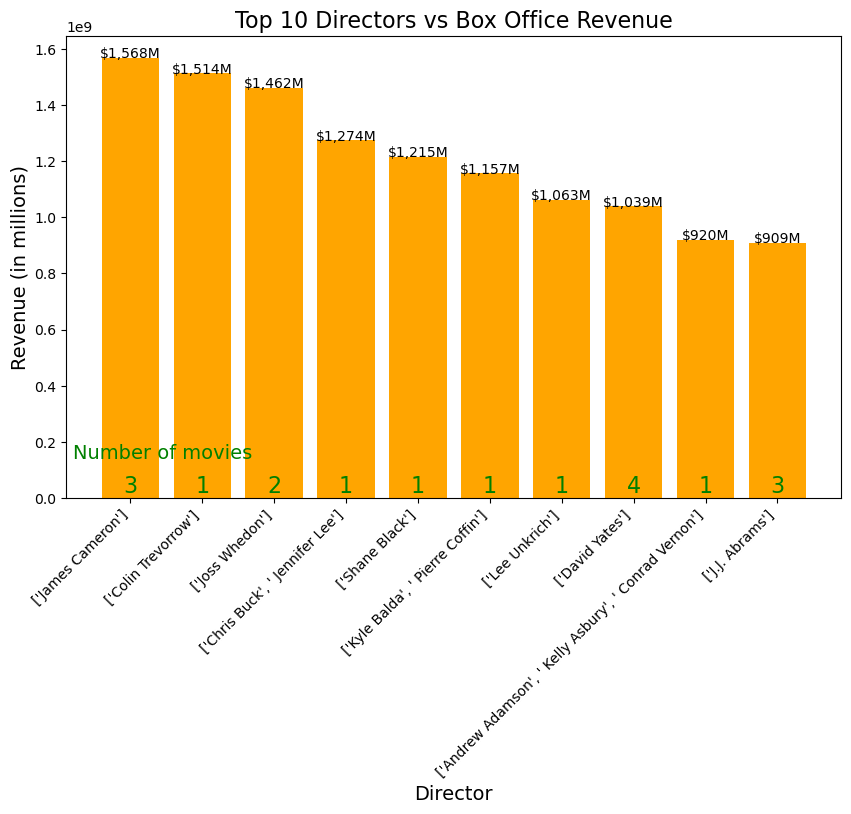

In [112]:
#Bar Chart on Director Vs Revenue
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(AllDirectors.index, AllDirectors['revenue'], color='orange')

for Rev, val in enumerate(AllDirectors['revenue']):
    ax.text(Rev, val, '${:,.0f}M'.format(val/1000000), ha='center')

for i, y in enumerate(AllDirectors['Title']):
    ax.text(i, y, '{:,.0f}'.format(y), ha='center', va='bottom', fontsize=16, color='green')

# set the title and axis labels
ax.set_title('Top 10 Directors vs Box Office Revenue', fontsize=16)
ax.set_xlabel('Director', fontsize=14)
ax.set_ylabel('Revenue (in millions)', fontsize=14)

# rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.annotate("Number of movies", (-.8,.14e9) ,fontsize=14,color="green")

# show the plot
plt.show()

In [67]:
director_multiple_movies = df.loc[df["director_movie_count"] >=5 ]
director_multiple_movies['Director'].value_counts()

['Steven Spielberg']        11
['John Carpenter']          10
['Steven Soderbergh']       10
['Peter Jackson']            8
['Clint Eastwood']           8
['Ridley Scott']             8
['Robert Zemeckis']          8
['David Fincher']            7
['Christopher Nolan']        7
['Ron Howard']               7
['Michael Bay']              6
['Paul W.S. Anderson']       6
['Francis Lawrence']         6
['Martin Campbell']          5
['Brian Robbins']            5
['Peter Berg']               5
['Marc Forster']             5
['Gore Verbinski']           5
['Tim Burton']               5
['Kevin Smith']              5
['Zack Snyder']              5
['Dennis Dugan']             5
['Martin Scorsese']          5
['Francis Ford Coppola']     5
['Sam Raimi']                5
['George Lucas']             5
['Darren Aronofsky']         5
['John Glen']                5
Name: Director, dtype: int64

In [68]:
#calculating top 10 directors based on revenue
High_Rev_directors = director_multiple_movies.groupby('Director').agg({'revenue': 'mean', 'Title': 'count'})
TopDirectors = High_Rev_directors.sort_values('revenue', ascending=False)[:10]
TopDirectors

,revenue,Title
Director,,
['Peter Jackson'],7.429554e+08,8
['George Lucas'],6.403102e+08,5
['Sam Raimi'],6.158115e+08,5
['Gore Verbinski'],6.033371e+08,5
['Christopher Nolan'],5.791191e+08,7
['Francis Lawrence'],5.299966e+08,6
['Michael Bay'],5.273964e+08,6
['Steven Spielberg'],4.779642e+08,11
['Tim Burton'],3.211713e+08,5


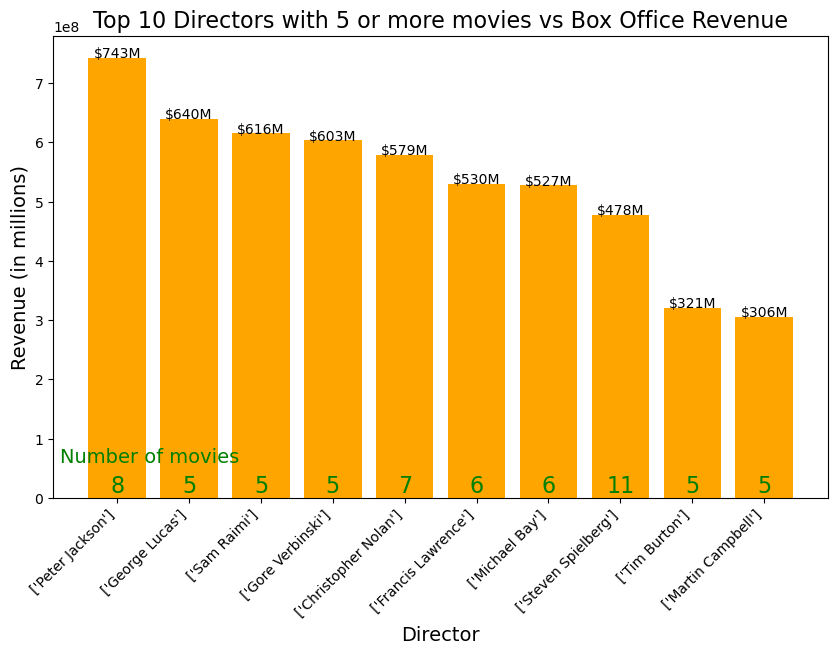

In [99]:
#Bar Chart on Director Vs Revenue
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(TopDirectors.index, TopDirectors['revenue'], color='orange')

for Rev, val in enumerate(TopDirectors['revenue']):
    ax.text(Rev, val, '${:,.0f}M'.format(val/1000000), ha='center')

for i, y in enumerate(TopDirectors['Title']):
    ax.text(i, y, '{:,.0f}'.format(y), ha='center', va='bottom', fontsize=16, color='green')


# set the title and axis labels
ax.set_title('Top 10 Directors with 5 or more movies vs Box Office Revenue', fontsize=16)
ax.set_xlabel('Director', fontsize=14)
ax.set_ylabel('Revenue (in millions)', fontsize=14)

# rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.annotate("Number of movies", (-.8,.6e8) ,fontsize=14,color="green")

# show the plot
plt.show()

In [114]:
#Runtime Percentile
df.Runtime.describe()

count    1172.000000
mean      111.094710
std        19.144613
min        63.000000
25%        97.000000
50%       108.000000
75%       122.000000
max       201.000000
Name: Runtime, dtype: float64

The r-squared is: 0.1304766512367599


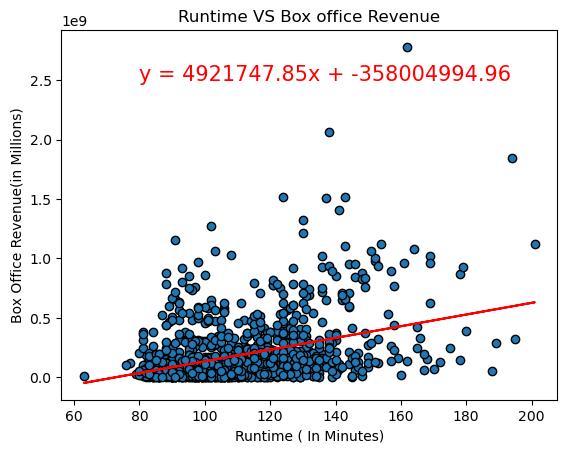

In [52]:
#Generating the Linear Regression

x_values = df['Runtime']
y_values = df['revenue']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, marker= "o", edgecolor ="black")
plt.title('Runtime VS Box office Revenue')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(80,25e8),fontsize=15,color="red")
plt.xlabel('Runtime ( In Minutes)')
plt.ylabel("Box Office Revenue(in Millions)")
print(f"The r-squared is: {rvalue**2}")
plt.show()